## Import libraries + set environments

In [ ]:
!pip install kagglehub --quiet

import kagglehub
import os, glob, re, json, cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from PIL import Image

import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.layers import Layer, Conv2D, LeakyReLU, Add
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input as vgg_preprocess
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [ ]:
# Set precision policy for numerical stability
print('TensorFlow version:', tf.__version__)

try:
  from tensorflow.keras import mixed_precision
  mixed_precision.set_global_policy('float32')
  print('Using float32 policy')
except Exception as e:
  print('Mixed precision config skipped:', e)

AUTOTUNE = tf.data.AUTOTUNE

TensorFlow version: 2.19.0
Using float32 policy


## Download and load dataset

In [ ]:
path = kagglehub.dataset_download("takihasan/div2k-dataset-for-super-resolution")
print('Dataset base path:', path)

HR_TRAIN = os.path.join(path, "Dataset/DIV2K_train_HR")
LR4_TRAIN = os.path.join(path, "Dataset/DIV2K_train_LR_bicubic_X4/X4")
HR_VAL = os.path.join(path, "Dataset/DIV2K_valid_HR")
LR4_VAL = os.path.join(path, "Dataset/DIV2K_valid_LR_bicubic_X4/X4")

print('HR_TRAIN:', os.path.isdir(HR_TRAIN), len(glob.glob(HR_TRAIN+'/*.png')))
print('LR4_TRAIN:', os.path.isdir(LR4_TRAIN), len(glob.glob(LR4_TRAIN+'/*.png')))
print('HR_VAL:', os.path.isdir(HR_VAL), len(glob.glob(HR_VAL+'/*.png')))
print('LR4_VAL:', os.path.isdir(LR4_VAL), len(glob.glob(LR4_VAL+'/*.png')))

Using Colab cache for faster access to the 'div2k-dataset-for-super-resolution' dataset.
Dataset base path: /kaggle/input/div2k-dataset-for-super-resolution
HR_TRAIN: True 800
LR4_TRAIN: True 800
HR_VAL: True 100
LR4_VAL: True 100


In [ ]:
# Robust filename normalization to generate multiple matching keys for LR-HR pairing
def normalize_basename_for_matching(p):
  name = os.path.splitext(os.path.basename(p))[0]
  keys = set([name])
  keys.add(re.sub(r'[_\.\-]?[xX]\d+$', '', name))
  keys.add(re.sub(r'[xX]\d+$', '', name))
  keys.add(re.sub(r'[_\.\-]?(b|bicubic)?[xX]\d+$', '', name))
  m = re.search(r'(\d{1,6})', name)
  if m: keys.add(m.group(1))
  keys.add(re.sub(r'[^0-9a-zA-Z]+$', '', name))
  return keys

# Flexible LR-HR pairing mechanism that matches images using normalized keys with numeric-ID fallback
def paired_paths_flexible(lr_dir, hr_dir):
  lr_files = sorted(glob.glob(os.path.join(lr_dir, '*.png')))
  hr_files = sorted(glob.glob(os.path.join(hr_dir, '*.png')))

  hr_index = defaultdict(list)
  for p in hr_files:
    for k in normalize_basename_for_matching(p):
      hr_index[k].append(p)

  paired_lr, paired_hr = [], []
  for lr_p in lr_files:
    matched = False
    for k in normalize_basename_for_matching(lr_p):
      if k in hr_index:
        candidates = hr_index[k]
        exact = [c for c in candidates if os.path.splitext(os.path.basename(c))[0] == k]
        hr_p = exact[0] if exact else candidates[0]
        paired_lr.append(lr_p); paired_hr.append(hr_p)
        matched = True
        break
    if not matched:
      name_lr = os.path.splitext(os.path.basename(lr_p))[0]
      m = re.search(r'(\d{1,6})', name_lr)
      if m:
        num = m.group(1)
        for h in hr_files:
          if num in os.path.splitext(os.path.basename(h))[0]:
            paired_lr.append(lr_p); paired_hr.append(h)
            matched = True
            break
  return paired_lr, paired_hr

# Construct LR-HR training and validation pairs using the flexible matching system
train_lr_paths, train_hr_paths = paired_paths_flexible(LR4_TRAIN, HR_TRAIN)
val_lr_paths, val_hr_paths = paired_paths_flexible(LR4_VAL, HR_VAL)

# Display total pairs and sample LR-HR pairings
print('Train pairs:', len(train_lr_paths), 'Val pairs:', len(val_lr_paths))
for i in range(min(5, len(train_lr_paths))):
  print(os.path.basename(train_lr_paths[i]), '->', os.path.basename(train_hr_paths[i]))

Train pairs: 800 Val pairs: 100
0001x4.png -> 0001.png
0002x4.png -> 0002.png
0003x4.png -> 0003.png
0004x4.png -> 0004.png
0005x4.png -> 0005.png


## Preprocessing and construct pipeline to extracts aligned LR-HR patches for ESRGAN training

In [ ]:
SCALE = 4
PATCH_HR = 224
PATCH_LR = PATCH_HR // SCALE
BATCH = 4
print('PATCH_LR:', PATCH_LR, '| PATCH_HR:', PATCH_HR)

# Load LR-HR image pair and convert both images to float32 tensors in the [0, 1] range
def load_pair(lr_path, hr_path):
  lr = tf.io.read_file(lr_path)
  lr = tf.image.decode_png(lr, channels=3)
  lr = tf.image.convert_image_dtype(lr, tf.float32)

  hr = tf.io.read_file(hr_path)
  hr = tf.image.decode_png(hr, channels=3)
  hr = tf.image.convert_image_dtype(hr, tf.float32)
  return lr, hr

# Randomly sample a spatially aligned LR-HR patch pair with a safety resize step when the original image is smaller than the patch size
def random_crop_pair(lr, hr):
  lr_h = tf.shape(lr)[0]
  lr_w = tf.shape(lr)[1]

  def resize_safe():
    lr_resized = tf.image.resize(lr, [PATCH_LR, PATCH_LR], method="bicubic")
    hr_resized = tf.image.resize(hr, [PATCH_HR, PATCH_HR], method="bicubic")
    return lr_resized, hr_resized

  if_resize = tf.logical_or(lr_h < PATCH_LR, lr_w < PATCH_LR)
  lr, hr = tf.cond(if_resize, resize_safe, lambda: (lr, hr))

  lr_h = tf.shape(lr)[0]
  lr_w = tf.shape(lr)[1]

  max_x = lr_h - PATCH_LR
  max_y = lr_w - PATCH_LR
  rx = tf.random.uniform([], 0, max_x + 1, dtype=tf.int32)
  ry = tf.random.uniform([], 0, max_y + 1, dtype=tf.int32)

  lr_patch = lr[rx:rx + PATCH_LR, ry:ry + PATCH_LR, :]
  hr_patch = hr[rx * SCALE: rx * SCALE + PATCH_HR, ry * SCALE: ry * SCALE + PATCH_HR, :]

  # Apply light data augmentation: flips and small contrast/brightness variations to improve robustness
  if tf.random.uniform([]) < 0.5:
    lr_patch = tf.image.flip_left_right(lr_patch)
    hr_patch = tf.image.flip_left_right(hr_patch)

  if tf.random.uniform([]) < 0.5:
    lr_patch = tf.image.flip_up_down(lr_patch)
    hr_patch = tf.image.flip_up_down(hr_patch)

  if tf.random.uniform([]) < 0.3:
    factor = tf.random.uniform([], 0.95, 1.05)
    lr_patch = tf.image.adjust_contrast(lr_patch, factor)
    hr_patch = tf.image.adjust_contrast(hr_patch, factor)

  if tf.random.uniform([]) < 0.3:
    delta = tf.random.uniform([], -0.03, 0.03)
    lr_patch = tf.clip_by_value(lr_patch + delta, 0.0, 1.0)
    hr_patch = tf.clip_by_value(hr_patch + delta, 0.0, 1.0)

  return lr_patch, hr_patch

# Extract centered LR-HR patch pair, resizing images if they are smaller than the desired patch size
def center_crop_pair(lr, hr):
  lr_h = tf.shape(lr)[0]
  lr_w = tf.shape(lr)[1]

  def resize_safe():
    lr_resized = tf.image.resize(lr, [PATCH_LR, PATCH_LR], method="bicubic")
    hr_resized = tf.image.resize(hr, [PATCH_HR, PATCH_HR], method="bicubic")
    return lr_resized, hr_resized

  if_resize = tf.logical_or(lr_h < PATCH_LR, lr_w < PATCH_LR)

  def crop_center():
    cy = lr_h // 2
    cx = lr_w // 2
    x0 = cy - PATCH_LR // 2
    y0 = cx - PATCH_LR // 2
    lr_patch = lr[x0:x0+PATCH_LR, y0:y0+PATCH_LR, :]
    hr_patch = hr[x0*SCALE:x0*SCALE+PATCH_HR, y0*SCALE:y0*SCALE+PATCH_HR, :]
    return lr_patch, hr_patch

  lr_patch, hr_patch = tf.cond(if_resize, resize_safe, crop_center)
  return lr_patch, hr_patch

# Build a tf.data pipeline that loads LR-HR pairs, applies patch extraction, augmentation, batch, and prefetch
def make_dataset(lr_paths, hr_paths, batch=BATCH, training=True):
  ds = tf.data.Dataset.from_tensor_slices((lr_paths, hr_paths))

  if training:
    ds = ds.shuffle(1000)

  def _load(l, h):
    lr, hr = tf.py_function(load_pair, [l, h], [tf.float32, tf.float32])
    lr.set_shape([None, None, 3])
    hr.set_shape([None, None, 3])
    return lr, hr

  ds = ds.map(_load, num_parallel_calls=AUTOTUNE)

  if training:
    ds = ds.map(random_crop_pair, num_parallel_calls=AUTOTUNE)
  else:
    ds = ds.map(center_crop_pair, num_parallel_calls=AUTOTUNE)

  ds = ds.batch(batch).prefetch(AUTOTUNE)
  return ds

train_ds = make_dataset(train_lr_paths, train_hr_paths, batch=BATCH, training=True)
val_ds = make_dataset(val_lr_paths, val_hr_paths, batch=BATCH, training=False)

# Set steps per epoch and val steps
steps_per_epoch = max(1, len(train_lr_paths) // BATCH)
val_steps = max(1, len(val_lr_paths) // BATCH)
print('steps_per_epoch:', steps_per_epoch, '| val_steps:', val_steps)

PATCH_LR: 56 | PATCH_HR: 224
steps_per_epoch: 200 | val_steps: 25


## RRDB based generator model

In [ ]:
# RRDB-based generator model used consistently for both training and inference.
class RDB(Layer):
  def __init__(self, filters=64, gc=32, **kwargs):
    super().__init__(**kwargs)
    self.filters = filters
    self.gc = gc

  def build(self, input_shape):
    self.c1 = Conv2D(self.gc, 3, padding='same')
    self.c2 = Conv2D(self.gc, 3, padding='same')
    self.c3 = Conv2D(self.gc, 3, padding='same')
    self.c4 = Conv2D(self.gc, 3, padding='same')
    self.c5 = Conv2D(self.filters, 3, padding='same')
    self.act = LeakyReLU(0.2)
    super().build(input_shape)

  def call(self, x):
    c1 = self.act(self.c1(x))
    c2 = self.act(self.c2(tf.concat([x, c1], axis=-1)))
    c3 = self.act(self.c3(tf.concat([x, c1, c2], axis=-1)))
    c4 = self.act(self.c4(tf.concat([x, c1, c2, c3], axis=-1)))
    c5 = self.c5(tf.concat([x, c1, c2, c3, c4], axis=-1))
    return x + 0.2 * c5

class RRDB(Layer):
  def __init__(self, filters=64, gc=32, **kwargs):
    super().__init__(**kwargs)
    self.filters = filters
    self.gc = gc

  def build(self, input_shape):
    self.rdb1 = RDB(self.filters, self.gc)
    self.rdb2 = RDB(self.filters, self.gc)
    self.rdb3 = RDB(self.filters, self.gc)
    super().build(input_shape)

  def call(self, x):
    out = self.rdb1(x)
    out = self.rdb2(out)
    out = self.rdb3(out)
    return x + 0.2 * out

class PixelShuffle(Layer):
  def __init__(self, scale=2, **kwargs):
    super().__init__(**kwargs)
    self.scale = scale

  def call(self, x):
    return tf.nn.depth_to_space(x, self.scale)

def conv_block(x, filters, k=3, s=1, act=True):
  x = Conv2D(filters, k, s, padding='same')(x)
  if act: x = LeakyReLU(0.2)(x)
  return x

def upsample_block(x, filters):
    x = Conv2D(filters * 4, 3, padding='same')(x)
    x = PixelShuffle(2)(x)
    x = LeakyReLU(0.2)(x)
    return x

# Build an RRDB-based generator with dynamic spatial input size to support arbitrary-resolution inference
def build_rrdb(num_rrdb=16, filters=64, gc=32, scale=SCALE):
  # Use dynamic height and width (None, None) so the model can infer on images of arbitrary spatial resolution
  inp = Input((None, None, 3))
  f1 = conv_block(inp, filters)
  x  = conv_block(f1, filters)

  for _ in range(num_rrdb):
    x = RRDB(filters=filters, gc=gc)(x)

  x = conv_block(x, filters)
  x = Add()([x, f1])

  for _ in range(int(np.log2(scale))):
    x = upsample_block(x, filters)

  # Final sigmoid activation constrains the RGB output to the [0, 1] intensity range
  out = Conv2D(3, 3, padding='same', activation='sigmoid', dtype='float32')(x)
  return Model(inp, out, name='RRDB')

generator = build_rrdb(num_rrdb=16, filters=64)
generator.summary()

Model: "RRDB"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, None,      │      1,792 │ input_layer[0][0] │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, None,      │          0 │ conv2d[0][0]      │
│ (LeakyReLU)         │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, None,      │     36,928 │ leaky_re_lu[0][0] │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, None,      │          0 │ conv2d_1[0][0]    │
│ (LeakyReLU)         │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rrdb (RRDB)         │ (None, None,      │    719,424 │ leaky_re_lu_1[0]… │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rrdb_1 (RRDB)       │ (None, None,      │    719,424 │ rrdb[0][0]        │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rrdb_2 (RRDB)       │ (None, None,      │    719,424 │ rrdb_1[0][0]      │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rrdb_3 (RRDB)       │ (None, None,      │    719,424 │ rrdb_2[0][0]      │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rrdb_4 (RRDB)       │ (None, None,      │    719,424 │ rrdb_3[0][0]      │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rrdb_5 (RRDB)       │ (None, None,      │    719,424 │ rrdb_4[0][0]      │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rrdb_6 (RRDB)       │ (None, None,      │    719,424 │ rrdb_5[0][0]      │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rrdb_7 (RRDB)       │ (None, None,      │    719,424 │ rrdb_6[0][0]      │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rrdb_8 (RRDB)       │ (None, None,      │    719,424 │ rrdb_7[0][0]      │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rrdb_9 (RRDB)       │ (None, None,      │    719,424 │ rrdb_8[0][0]      │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rrdb_10 (RRDB)      │ (None, None,      │    719,424 │ rrdb_9[0][0]      │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rrdb_11 (RRDB)      │ (None, None,      │    719,424 │ rrdb_10[0][0]   

 Total params: 11,883,587 (45.33 MB)

 Trainable params: 11,883,587 (45.33 MB)

 Non-trainable params: 0 (0.00 B)

## VGG19-based perceptual feature extractor (block4_conv4) used only during training to compute perceptual loss and encourage sharper textures and more realistic details


In [ ]:
# Adjust the VGG input resolution to match PATCH_HR = 224
vgg = VGG19(
    weights='imagenet',
    include_top=False,
    input_shape=(PATCH_HR, PATCH_HR, 3)
)
vgg.trainable = False

# Use block4_conv4 feature map for stronger sensitivity to mid-level textures and edge structures
feat_layer = vgg.get_layer('block4_conv4').output
feature_extractor = Model(inputs=vgg.input, outputs=feat_layer)
feature_extractor.trainable = False

# Constructs the combined ESRGAN loss: L1/mae, gradient-based edge loss, and VGG perceptual loss
def esrgan_loss_wrapper(w_l1=1.0, w_vgg=0.01, w_grad=0.2):
  def loss_fn(y_true, y_pred):

    # L1 reconstruction loss
    l1 = tf.reduce_mean(tf.abs(y_true - y_pred))

    # Gradient-based edge loss
    dy_true, dx_true = tf.image.image_gradients(y_true)
    dy_pred, dx_pred = tf.image.image_gradients(y_pred)

    grad_true = tf.abs(dx_true) + tf.abs(dy_true)
    grad_pred = tf.abs(dx_pred) + tf.abs(dy_pred)

    grad_loss = tf.reduce_mean(tf.abs(grad_true - grad_pred))

    # VGG19 perceptual loss
    hr_proc = vgg_preprocess(y_true * 255.0)
    sr_proc = vgg_preprocess(y_pred * 255.0)

    hr_feat = feature_extractor(hr_proc)
    sr_feat = feature_extractor(sr_proc)

    vgg_loss = tf.reduce_mean(tf.square(hr_feat - sr_feat))

    total = w_l1 * l1 + w_grad * grad_loss + w_vgg * vgg_loss
    return total

  return loss_fn

perceptual_loss = esrgan_loss_wrapper(
    w_l1=1.0,
    w_vgg=0.015,  # bigger -> more perceptual
    w_grad=0.3    # bigger -> sharper the edge
)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


## Train Model

In [ ]:
check_dir = '/content/checkpoints_esrgan_lite'
os.makedirs(check_dir, exist_ok=True)

# Callbacks for saving checkpoint
ckpt = ModelCheckpoint(
    os.path.join(check_dir, 'esrgan_lite_epoch{epoch:02d}.keras'),
    save_weights_only=False,
    save_freq='epoch'
)

# Learning rate scheduler
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=8,
    min_lr=5e-6
)

WARMUP_EPOCHS = 5
MAIN_EPOCHS = 200

# Warmup training using pure L1/mae loss to stabilize color reproduction and basic pixel mapping
generator.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4),
    loss='mae',
    metrics=['mae']
)

history_w = generator.fit(
    train_ds.repeat(),
    epochs=WARMUP_EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    validation_steps=val_steps
)

# Main training phase using the combined / full perceptual loss (L1 + edge loss + VGG feature loss) for sharper and more realistic reconstruction
generator.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=perceptual_loss,
    metrics=['mae']
)

print("Switched to combined loss: L1 + Edge/Grad + VGG Perceptual.")

history_main = generator.fit(
    train_ds.repeat(),
    epochs=MAIN_EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    validation_steps=val_steps,
    callbacks=[ckpt, reduce_lr]
)

Epoch 1/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 116s 132ms/step - loss: 0.1600 - mae: 0.1600 - val_loss: 0.0786 - val_mae: 0.0786
Epoch 2/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - loss: 0.0611 - mae: 0.0611 - val_loss: 0.0634 - val_mae: 0.0634
Epoch 3/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - loss: 0.0527 - mae: 0.0527 - val_loss: 0.0582 - val_mae: 0.0582
Epoch 4/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - loss: 0.0485 - mae: 0.0485 - val_loss: 0.0489 - val_mae: 0.0489
Epoch 5/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - loss: 0.0451 - mae: 0.0451 - val_loss: 0.0458 - val_mae: 0.0458
Switched to combined loss: L1 + Edge/Grad + VGG Perceptual.
Epoch 1/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 124s 152ms/step - loss: 165.0158 - mae: 0.0662 - val_loss: 223.4461 - val_mae: 0.0614 - learning_rate: 1.0000e-04
Epoch 2/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 24s 120ms/step - loss: 147.3997 - mae: 0.0568 - val_loss: 213.3361 - val_mae: 0.0572 - learning_rate: 1.0000e-04
Epoch 3/200
200/200 ━━━━━━━━━━

In [ ]:
# Save model
generator.save('/content/esrgan_lite_full.keras')
print('Saved model to /content/esrgan_lite_full.keras')

Saved model to /content/esrgan_lite_full.keras


## Visualize LR, SR, and HR using sample from the validation set

Quick check:
  LR resolution : 510×339
  SR resolution : 2040×1356
  HR resolution : 2040×1356


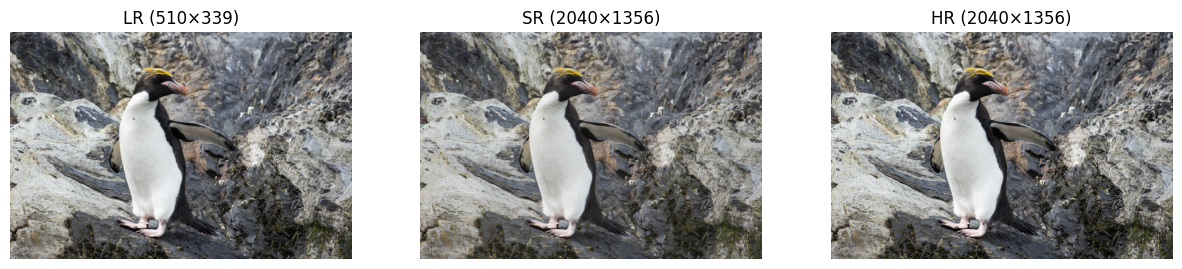

In [ ]:
# Apply simple sharpening kernel, optional for post-processing
def post_sharpen(img):
  kernel = np.array([[0, -1,  0],
                      [-1,  5, -1],
                      [0, -1,  0]], dtype=np.float32)
  return cv2.filter2D(img, -1, kernel)

# Return string of image resolution
def _res_str(img):
  h, w = img.shape[:2]
  return f"{w}×{h}"

# Display LR (Low Res), SR (Super Res generated from model), and HR (High Res) images side by side for visual comparison
def show_triple(lr_img, sr_img, hr_img=None):
  plt.figure(figsize=(15, 5))

  # LR
  plt.subplot(1, 3, 1)
  plt.title(f"LR ({_res_str(lr_img)})")
  plt.axis('off')
  plt.imshow(np.clip(lr_img, 0, 1))

  # SR
  plt.subplot(1, 3, 2)
  plt.title(f"SR ({_res_str(sr_img)})")
  plt.axis('off')
  plt.imshow(np.clip(sr_img, 0, 1))

  # HR (if exists)
  if hr_img is not None:
    plt.subplot(1, 3, 3)
    plt.title(f"HR ({_res_str(hr_img)})")
    plt.axis('off')
    plt.imshow(np.clip(hr_img, 0, 1))

  plt.show()

# Run super-resolution inference on a single LR image
def upscale_image(path, model, save_to=None, use_sharpen=False):
  # Load LR image
  img = Image.open(path).convert('RGB')
  lr = np.array(img).astype('float32') / 255.0  # [0,1]

  # Generate super-resolved output
  sr = model.predict(lr[None, ...], verbose=0)[0]  # [0,1]
  sr = np.clip(sr, 0.0, 1.0)

  # Convert to uint8 and optionally apply sharpening
  sr_img = (sr * 255.0).astype('uint8')
  if use_sharpen:
    sr_img = post_sharpen(sr_img)

  # Convert back to float32
  sr_f32 = sr_img.astype('float32') / 255.0

  # Save SR output to file
  if save_to is not None:
    Image.fromarray(sr_img).save(save_to)

  return lr, sr_f32

# Visualization using one sample from the validation set
if len(val_lr_paths) > 0:
  lr_path = val_lr_paths[0]
  hr_path = val_hr_paths[0]

  lr = tf.image.convert_image_dtype(
      tf.io.decode_png(tf.io.read_file(lr_path), channels=3),
      tf.float32
  ).numpy()

  hr = tf.image.convert_image_dtype(
      tf.io.decode_png(tf.io.read_file(hr_path), channels=3),
      tf.float32
  ).numpy()

  sr = generator.predict(lr[None, ...], verbose=0)[0]
  sr = np.clip(sr, 0.0, 1.0)

  # Display visualization
  print(f"Quick check:")
  print(f"  LR resolution : {_res_str(lr)}")
  print(f"  SR resolution : {_res_str(sr)}")
  print(f"  HR resolution : {_res_str(hr)}")

  show_triple(lr, sr, hr)

## Test model for uploaded low-resolution images

Inference model loaded from: /content/esrgan_lite_full.keras
Please upload LR image to be upscaled:


Saving 0823x2.png to 0823x2.png

Uploaded file: 0823x2.png

Super Resolution Results
Input  (LR) : 0823x2.png  | resolution = 1020×642
Output (SR) : /content/sr_output.png | resolution = 4080×2568


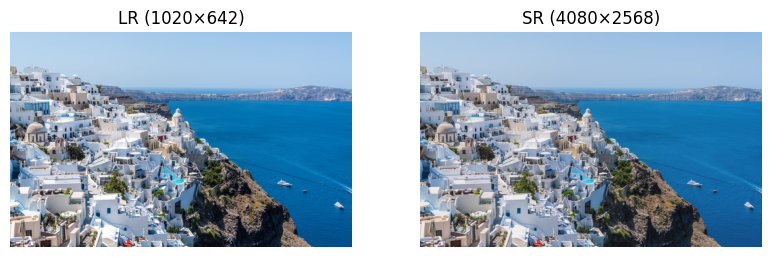

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Import libraries
from tensorflow.keras.models import load_model
from google.colab import files
import io

# Load model
INFER_MODEL_PATH = "/content/esrgan_lite_full.keras"

gen_infer = load_model(
    INFER_MODEL_PATH,
    custom_objects={
        'RDB': RDB,
        'RRDB': RRDB,
        'PixelShuffle': PixelShuffle
    },
    compile=False
)

print("Inference model loaded from:", INFER_MODEL_PATH)

# Upload LR image that will be upscaled by the ESRGAN model
print("Please upload LR image to be upscaled:")
uploaded = files.upload()

input_path = list(uploaded.keys())[0]
print(f"\nUploaded file: {input_path}")

output_path = "/content/sr_output.png"

lr_img, sr_img = upscale_image(
    input_path,
    gen_infer,
    save_to=output_path,
    use_sharpen=False   # set to True to activate sharpening
)

print("\nSuper Resolution Results")
print(f"Input  (LR) : {input_path}  | resolution = {_res_str(lr_img)}")
print(f"Output (SR) : {output_path} | resolution = {_res_str(sr_img)}")

show_triple(lr_img, sr_img, hr_img=None)
files.download(output_path)